In [282]:
import os
import sys
import json
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import functools
import numpy as np
import math
import random
import scipy
import yaml
from scipy import stats

sys.path.append(os.path.abspath(".."))
import plotting
import utils

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from data_loader import get_dataset, CustomDataset

## Load results

In [283]:
RESULTS_FILE = '../results/concept_eval/prep_results_transfer.csv'

In [284]:
df = pd.read_csv(RESULTS_FILE)
df

,Unnamed: 0,dataset train,dataset test,model,model type,architecture,pooling,classifier,clf hidden size factor,emb size,optimizer,lr,loss,group,PR-AUC,attribute,group_standardized
0,18,ImplicitHate,ImplicitHate,microsoft/deberta-v3-large,deberta,encoder,mean,linear,-1.0,1024,Salsa,NaN,BCEWithLogitsLoss,mean,0.096274,NaN,NaN
1,19,ImplicitHate,ImplicitHate,microsoft/deberta-v3-large,deberta,encoder,mean,linear,-1.0,1024,Salsa,NaN,BCEWithLogitsLoss,female,0.014929,gender_sexual_orientation,female
2,20,ImplicitHate,ImplicitHate,microsoft/deberta-v3-large,deberta,encoder,mean,linear,-1.0,1024,Salsa,NaN,BCEWithLogitsLoss,male,0.012225,gender_sexual_orientation,male
3,21,ImplicitHate,ImplicitHate,microsoft/deberta-v3-large,deberta,encoder,mean,linear,-1.0,1024,Salsa,NaN,BCEWithLogitsLoss,homosexual,0.013935,gender_sexual_orientation,homosexual
4,22,ImplicitHate,ImplicitHate,microsoft/deberta-v3-large,deberta,encoder,mean,linear,-1.0,1024,Salsa,NaN,BCEWithLogitsLoss,lgbtq+,0.002713,gender_sexual_orientation,lgbtq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11125,6445,SBIC,StereoSet,xlnet/xlnet-large-cased,xlnet,decoder,mean,MLP2,1.0,1024,Salsa,NaN,BCEWithLogitsLoss,male,0.275098,gender_sexual_orientation,male
11126,6446,SBIC,StereoSet,xlnet/xlnet-large-cased,xlnet,decoder,mean,MLP2,1.0,1024,Salsa,NaN,BCEWithLogitsLoss,female,0.425631,gender_sexual_orientation,female
11127,6447,SBIC,StereoSet,xlnet/xlnet-large-cased,xlnet,decoder,mean,MLP2,1.0,1024,Salsa,NaN,BCEWithLogitsLoss,christian,0.130200,religion,christian
11128,6448,SBIC,StereoSet,xlnet/xlnet-large-cased,xlnet,decoder,mean,MLP2,1.0,1024,Salsa,NaN,BCEWithLogitsLoss,muslim,0.261707,religion,muslim


In [286]:
df_mean = df[df['group'] == 'mean']
df_groups = df[df['group'] != 'mean']

## Utils

In [287]:
def aggregate_results(results, sel_cols, target_col):
    grouped_res = results.groupby(sel_cols, as_index=False)[target_col].mean().reset_index()
    grouped_res[target_col+' var'] = results.groupby(sel_cols, as_index=False)[target_col].var()[target_col]
    return grouped_res

def boxplot(results, ax, xcol, ycol, huecol, title, remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0, xlabel_rotation=0, fix_ylim=True, order=False):
    # mark 0 with hline
    ax.hlines(y=0, xmin=-1, xmax=len(set(results[xcol])), linewidth=0.5, color='black')

    # do boxplot
    if huecol is not None:
        sns.boxplot(data=results, x=xcol, y=ycol, hue=huecol, ax=ax)
    else:
        if order:
            order = (
                results.groupby(xcol)[ycol]
                .median()
                .sort_values()
                .index
            )
            sns.boxplot(data=results, x=xcol, y=ycol, ax=ax, order=order)
        else:
            sns.boxplot(data=results, x=xcol, y=ycol, ax=ax)

    if fix_ylim:
        ax.set_ylim(-0.05, 1.05)

    # set title and labels/ change fontsize
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('')
    if add_ylabel:
        ax.set_ylabel(ycol, fontsize=14)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)
    
    # set lenged if required, set ylim to make space for legend
    ax.set_ylim(ymin, ymax)
    legend = ax.legend(fontsize=14)
    if remove_legend:
        legend.remove()

def multiplot(results, subplot_col, xcol, ycol, huecol, title=None, remove_legend=False, savefile=None, xlabel_rotation=0):
    # create a subplot for unique value in subplot_col
    subplot_choices = list(set(results.loc[:,subplot_col]))
    fig, axes = plt.subplots(1, len(subplot_choices), figsize=(7*len(subplot_choices), 6))

    # do boxplot for each value in subplot_col
    if len(subplot_choices) == 1:
        boxplot(results, axes, xcol=xcol, ycol=ycol, huecol=huecol, title=subplot_choices[0], add_ylabel=True)
    else:
        for i, val in enumerate(subplot_choices):
            res_filt = results.loc[results[subplot_col] == val]
            boxplot(res_filt, axes[i], xcol=xcol, ycol=ycol, huecol=huecol, title=val, add_ylabel=(i==0), xlabel_rotation=xlabel_rotation)
    if title is not None:
        plt.suptitle(title)
    
    # (save and) show figure
    if savefile is not None:
        if '.eps' in savefile:
            plt.savefig(savefile, format='eps', bbox_inches='tight')
        else:
            plt.savefig(savefile, bbox_inches='tight')
    plt.show()

## Run t-test

Since we picked those models that performed better (in general or particularly well on some datasets) with MLP, it makes sense that this t-test does not show significantly better results for the linear classifier (in-domain).  
In the transfer case though, the t-test indicates that linear classifiers perform better compared to in-domain, but the results are not statistically significant!

In [288]:
df_lin = df_groups[df_groups['classifier'] == 'linear']
df_mlp = df_groups[df_groups['classifier'] == 'MLP2']

In [289]:
columns = ['model', 'dataset train', 'dataset test', 'group']

def run_ttest(df_mlp, df_lin, columns, alternative='greater'):
    auc_lin = []
    auc_mlp = []
    for i in range(len(df_lin)):
        lin_row = df_lin.iloc[i]
        mlp_matches = df_mlp[df_mlp.apply(lambda mlp_row: all(mlp_row[col] == lin_row[col] for col in columns), axis=1)]
    
        if len(mlp_matches) == 1:
            auc_lin.append(lin_row['PR-AUC'])
            auc_mlp.append(mlp_matches['PR-AUC'].squeeze())
    
    auc_lin = np.asarray(auc_lin)
    auc_mlp = np.asarray(auc_mlp)
    
    t_stat, p_value = stats.ttest_rel(auc_lin, auc_mlp, alternative=alternative)
    
    return t_stat, p_value, np.mean(auc_lin), np.mean(auc_mlp), auc_mlp-auc_lin

print("Hypothesis: AUC scores of linear models are bigger than those of MLP models")
stat, pval, mean_lin, mean_mlp, diff = run_ttest(df_mlp[df_mlp['dataset train'] == df_mlp['dataset test']], df_lin[df_lin['dataset train'] == df_lin['dataset test']], columns)
print("t-test (in-domain): ", stat, pval)
print(mean_lin, mean_mlp)
print()
stat, pval, mean_lin, mean_mlp, diff = run_ttest(df_mlp[df_mlp['dataset train'] != df_mlp['dataset test']], df_lin[df_lin['dataset train'] != df_lin['dataset test']], columns)
print("t-test (transfer): ", stat, pval)
print(mean_lin, mean_mlp)

Hypothesis: AUC scores of linear models are bigger than those of MLP models
t-test (in-domain):  -0.31725642501700724 0.6243576827012614
0.1765250283717426 0.18182828811803634

t-test (transfer):  1.2901043794336304 0.09856883993954904
0.278465300956615 0.27364465014868045


## Confusion matrix

Confusion matrix for MLP/ linear with all datasets (maybe just one model or mean over all?) -> see transfer and in-domain performance.
Or do the PR-AUC diff in confusion matrix

In [290]:
df_lin = df_mean[df_mean['classifier'] == 'linear']
df_mlp = df_mean[df_mean['classifier'] == 'MLP2']

In [291]:
df_mlp

,Unnamed: 0,dataset train,dataset test,model,model type,architecture,pooling,classifier,clf hidden size factor,emb size,optimizer,lr,loss,group,PR-AUC,attribute,group_standardized
4914,6,WinoQueer,WinoQueer,microsoft/deberta-v3-large,deberta,encoder,mean,MLP2,1.0,1024,Salsa,NaN,BCEWithLogitsLoss,mean,0.999156,NaN,NaN
4928,20,WinoQueer,CrowSPairs,microsoft/deberta-v3-large,deberta,encoder,mean,MLP2,1.0,1024,Salsa,NaN,BCEWithLogitsLoss,mean,0.015064,NaN,NaN
4932,24,SBIC,SBIC,microsoft/deberta-v3-large,deberta,encoder,mean,MLP2,1.0,1024,Salsa,NaN,BCEWithLogitsLoss,mean,0.066928,NaN,NaN
5008,100,SBIC,BIOS,microsoft/deberta-v3-large,deberta,encoder,mean,MLP2,1.0,1024,Salsa,NaN,BCEWithLogitsLoss,mean,0.502852,NaN,NaN
5011,103,SBIC,CrowSPairs,microsoft/deberta-v3-large,deberta,encoder,mean,MLP2,1.0,1024,Salsa,NaN,BCEWithLogitsLoss,mean,0.077752,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10997,6314,SBIC,SBIC,xlnet/xlnet-large-cased,xlnet,decoder,mean,MLP2,1.0,1024,Salsa,NaN,BCEWithLogitsLoss,mean,0.154189,NaN,NaN
11073,6390,SBIC,ImplicitHate,xlnet/xlnet-large-cased,xlnet,decoder,mean,MLP2,1.0,1024,Salsa,NaN,BCEWithLogitsLoss,mean,0.069432,NaN,NaN
11092,6409,SBIC,WinoQueer,xlnet/xlnet-large-cased,xlnet,decoder,mean,MLP2,1.0,1024,Salsa,NaN,BCEWithLogitsLoss,mean,0.064369,NaN,NaN
11099,6419,SBIC,Jigsaw,xlnet/xlnet-large-cased,xlnet,decoder,mean,MLP2,1.0,1024,Salsa,NaN,BCEWithLogitsLoss,mean,0.238815,NaN,NaN


In [292]:
auc_lin = []
auc_mlp = []
data = {'dataset train': [], 'dataset test': [], 'linear': [], 'mlp': [], 'model': []}

columns = ['model', 'dataset train', 'dataset test', 'group']
for i in range(len(df_lin)):
    lin_row = df_lin.iloc[i]
    mlp_matches = df_mlp[df_mlp.apply(lambda mlp_row: all(mlp_row[col] == lin_row[col] for col in columns), axis=1)]

    if len(mlp_matches) > 0:
        data['linear'].append(lin_row['PR-AUC'])
        data['mlp'].append(mlp_matches['PR-AUC'].mean())#.squeeze())
        data['dataset train'].append(lin_row['dataset train'])
        data['dataset test'].append(lin_row['dataset test'])
        data['model'].append(lin_row['model'])

res = pd.DataFrame(data)
res['diff'] = res['mlp'] - res['linear']
res

,dataset train,dataset test,linear,mlp,model,diff
0,ImplicitHate,ImplicitHate,0.096274,0.047427,microsoft/deberta-v3-large,-0.048847
1,ImplicitHate,WinoQueer,0.058563,0.091141,microsoft/deberta-v3-large,0.032578
2,ImplicitHate,SBIC,0.079315,0.037452,microsoft/deberta-v3-large,-0.041863
3,ImplicitHate,BIOS,0.503768,0.493737,microsoft/deberta-v3-large,-0.010031
4,ImplicitHate,Jigsaw,0.047683,0.045824,microsoft/deberta-v3-large,-0.001859
...,...,...,...,...,...,...
396,SBIC,WinoQueer,0.229999,0.091150,deepseek-ai/deepseek-llm-7b-base,-0.138848
397,SBIC,BIOS,0.520307,0.722673,deepseek-ai/deepseek-llm-7b-base,0.202366
398,SBIC,Jigsaw,0.186787,0.098949,deepseek-ai/deepseek-llm-7b-base,-0.087838
399,SBIC,CrowSPairs,0.207866,0.112982,deepseek-ai/deepseek-llm-7b-base,-0.094883


## Heatmap: MLP and linear

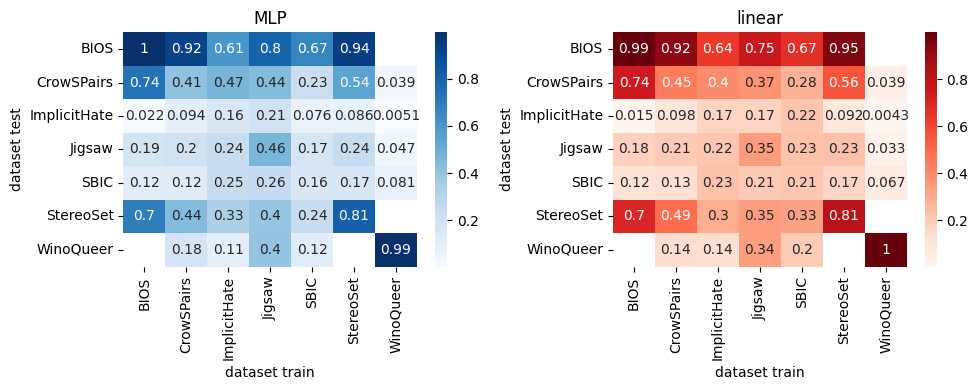

In [293]:
agg_res = res.groupby(["dataset test", "dataset train"], as_index=False)[["mlp", "linear", "diff"]].mean()

pivot1 = agg_res.pivot(index="dataset test", columns="dataset train", values="mlp")
pivot2 = agg_res.pivot(index="dataset test", columns="dataset train", values="linear") # linear

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(pivot1, ax=axes[0], annot=True, cmap="Blues")
axes[0].set_title("MLP")

sns.heatmap(pivot2, ax=axes[1], annot=True, cmap="Reds")
axes[1].set_title("linear")

plt.tight_layout()
plt.show()

### just MLP for the paper, color adapted to fit the diff plot

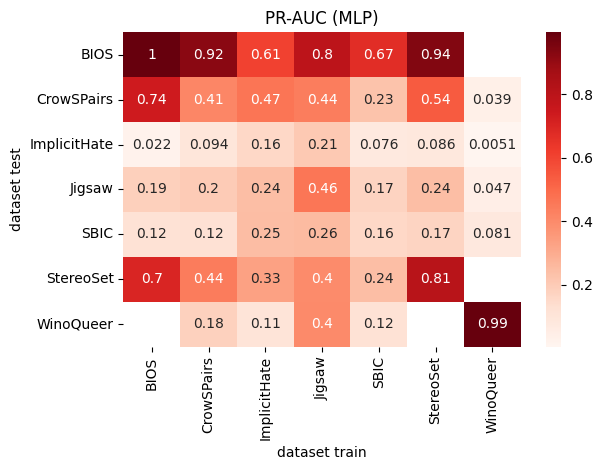

In [294]:
pivot1 = agg_res.pivot(index="dataset test", columns="dataset train", values="mlp")

sns.heatmap(pivot1, annot=True, cmap="Reds")
plt.title("PR-AUC (MLP)")

plt.tight_layout()
plt.savefig('../plots/heatmap_mlp.eps', format='eps', bbox_inches='tight')
plt.show()

### Heatmap with performance diff (MLP - linear) - for paper

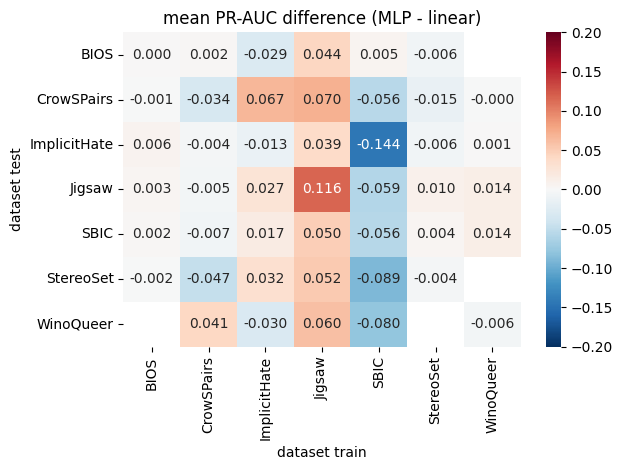

In [278]:
agg_res = res.groupby(["dataset test", "dataset train"], as_index=False)[["mlp", "linear", "diff"]].mean()
pivot1 = agg_res.pivot(index="dataset test", columns="dataset train", values="diff")

sns.heatmap(pivot1, annot=True, cmap="RdBu_r", fmt=".3f", center=0, vmax=0.2, vmin=-0.2)
plt.title("mean PR-AUC difference (MLP - linear)")

plt.tight_layout()
plt.savefig('../plots/heatmap_diff_mean.eps', format='eps', bbox_inches='tight')
plt.show()

### Variance of performance diff between the models

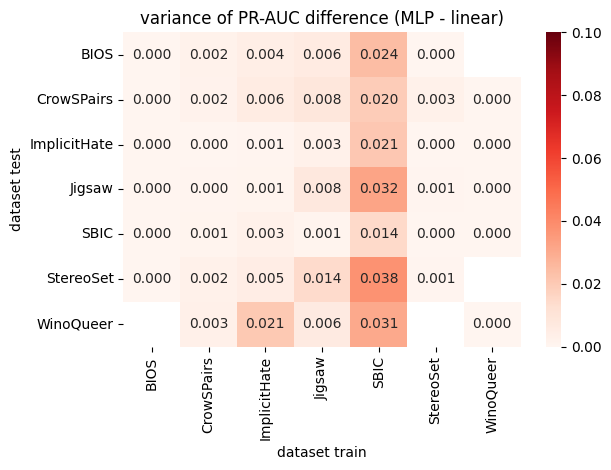

In [279]:
agg_res = res.groupby(["dataset test", "dataset train"], as_index=False)[["mlp", "linear", "diff"]].var()

pivot1 = agg_res.pivot(index="dataset test", columns="dataset train", values="diff")

sns.heatmap(pivot1, annot=True, cmap="Reds", fmt=".3f", vmin=0, vmax=0.1)
plt.title("variance of PR-AUC difference (MLP - linear)")

plt.tight_layout()
plt.savefig('../plots/heatmap_diff_var.eps', format='eps', bbox_inches='tight')
plt.show()

### Heatmaps for individual models

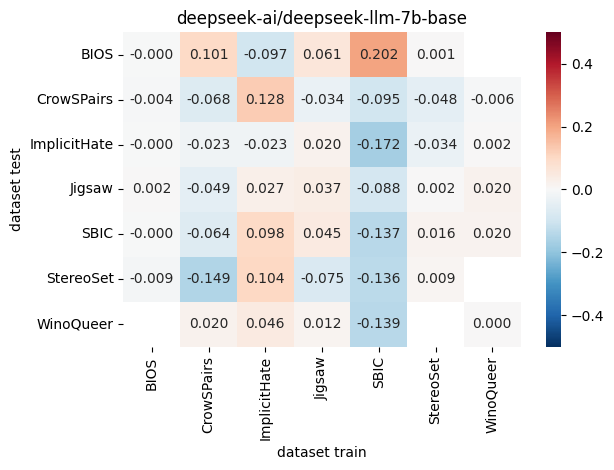

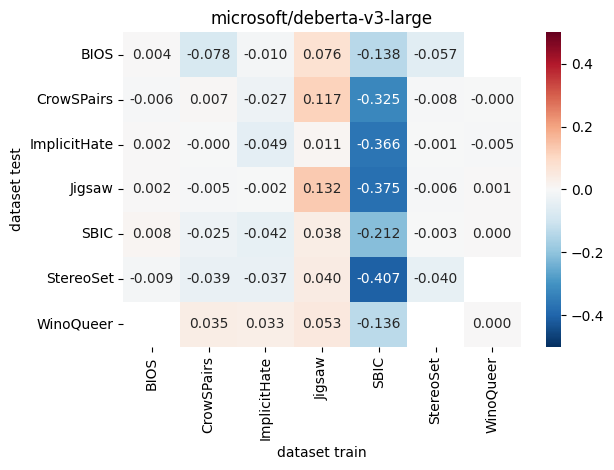

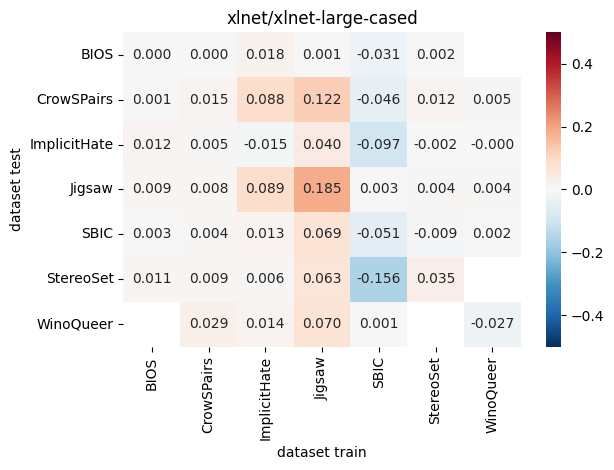

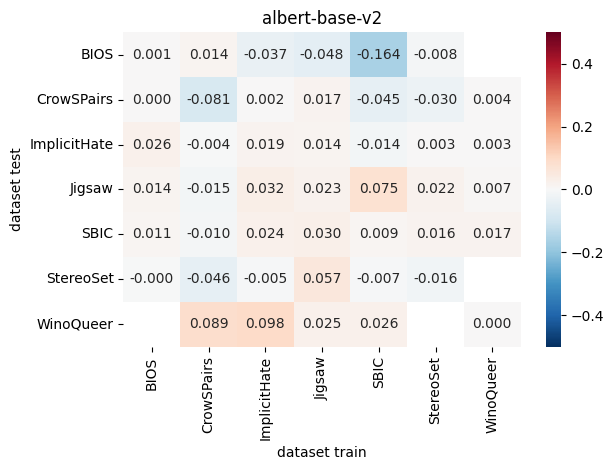

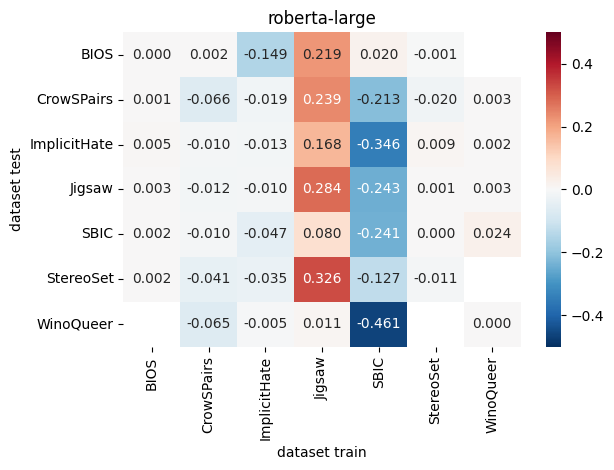

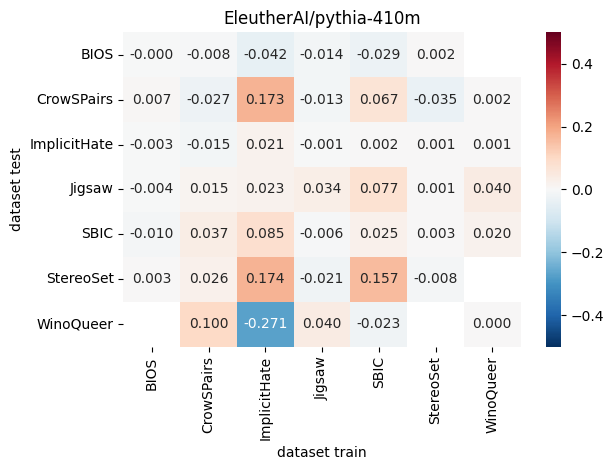

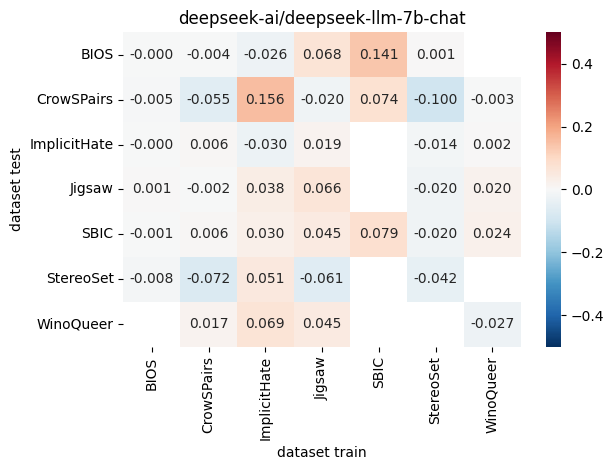

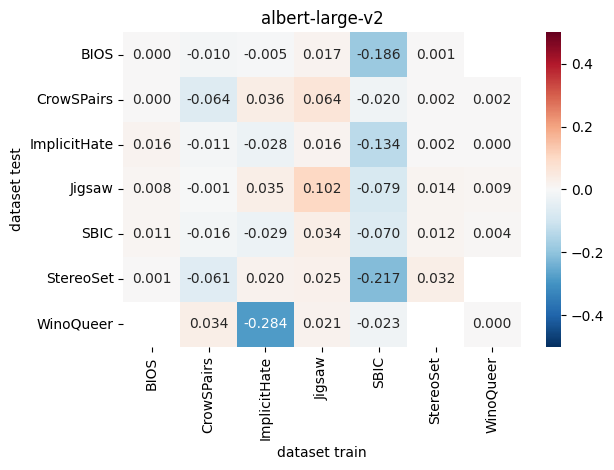

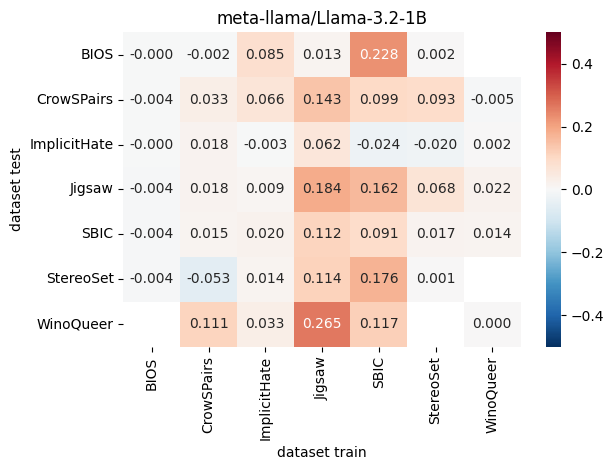

In [280]:
for model in set(res['model']):
    model_str = model
    if '/' in model_str:
        model_str = model_str.split('/')[1]
    res_model = res[res['model'] == model]
    agg_res_ = res_model.groupby(["dataset test", "dataset train"], as_index=False)[["mlp", "linear", "diff"]].mean()
    pivot1 = agg_res_.pivot(index="dataset test", columns="dataset train", values="diff")
    
    sns.heatmap(pivot1, annot=True, cmap="RdBu_r", fmt=".3f", center=0, vmin=-0.5, vmax=0.5)
    plt.title(model)
    
    plt.tight_layout()
    plt.savefig(('../plots/heatmap_diff_%s.eps' % model_str), format='eps', bbox_inches='tight')
    plt.show()